In [306]:
import os
import glob
import yaml  # You'll need to install the PyYAML library for YAML parsing
from cloudmesh.common.FlatDict import FlatDict
from pprint import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the directory where you want to start the search
start_directory = 'project/'

# Initialize an empty dictionary to store the results
result = []

# Use a recursive search to find all files matching the pattern
for root, dirs, files in os.walk(start_directory):
    for file in files:
        if file.startswith('result') and file.endswith('.out'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                csv_lines = [line.strip() for line in lines if line.startswith("# csv")]
                try:
                    result_line = [line.replace(":::MLLOG", "").strip() for line in lines if line.startswith(":::MLLOG") and '"result"' in line][0]
                    result_line = eval(result_line)
                    
                    for k in ['event_type', 'key', 'metadata', 'namespace', 'time_ms']:
                        del result_line[k]
                    
                except:
                    result_line = None
                csv_dict = {}
                for line in csv_lines[1:]:  # Skip the header line
                    line_parts = line.split(',')
                    timer_key = line_parts[1]
                    csv_dict[timer_key] = float(line_parts[3])
            
                if csv_lines:
                    config_path = os.path.join(root, 'config.yaml')
                    config = FlatDict()
                    try:
                        config.loadf(filename=config_path)
                    except:
                        config = None
                    # filter only the "experiment." values

                    filtered = {key.replace("experiment.",""): value 
                                for key, value in dict(config).items() if key.startswith('experiment.')}
                    entry = {
                        'name': file
                    }
                    entry.update(csv_dict)
                    entry.update(filtered)
                    entry.update({"result": result_line})
                    result.append(entry)


# Print the dictionary with the results, including the config
# for filename, data in result_dict.items():
#     print(f'File: {filename}')
#     print('CSV Lines:')
#     for line in data['csv_lines']:
#         print(line)
#    print('Config:')
#    for key, value in data['config'].items():
#        print(f'{key}: {value}')

#pprint(result_dict)

In [307]:
pprint(result[0])

result_data = result.copy()


{'batch_size': 32,
 'card_name': 'v100',
 'clip_offset': 15,
 'cpu_num': 1,
 'directive': 'v100',
 'early_stoppage': 'False',
 'early_stoppage_patience': '25',
 'epoch': '70',
 'gpu': 1,
 'gpu_count': '1',
 'inference': 144.679,
 'learning_rate': 0.001,
 'loaddata': 4.118,
 'mem': '64GB',
 'name': 'result-thf2bn-53854471.out',
 'no_cache': False,
 'nodes': 1,
 'repeat': '5',
 'result': {'value': {'inference': {'accuracy': [0.9233438888888889,
                                                 0.9345094444444444,
                                                 0.8940772222222222,
                                                 0.9105144444444444,
                                                 0.8391288888888889,
                                                 0.95098,
                                                 0.8876861111111111,
                                                 0.7732322222222222,
                                                 0.8472777777777778,
            

In [308]:
df = pd.DataFrame(result)
print(df.columns)

for c in ['epoch', 'repeat']:
    df[c] = df[c].astype(int)
for c in ['total', 'training', 'loaddata', 'inference']:
    df[c] = df[c].astype(float)

df = df.drop(columns=['name', 'mem', 'gpu_count', 'cpu_num', 'seed', 'batch_size', 'clip_offset', 'no_cache', 'gpu', 'nodes', 'train_split', 'learning_rate', 'early_stoppage', 'early_stoppage_patience', 'card_name', 'training_on_mutiple_GPU'])
df


Index(['name', 'total', 'training', 'loaddata', 'inference', 'directive',
       'gpu_count', 'cpu_num', 'mem', 'repeat', 'epoch', 'seed',
       'learning_rate', 'batch_size', 'train_split', 'clip_offset', 'no_cache',
       'nodes', 'gpu', 'early_stoppage_patience', 'early_stoppage',
       'card_name', 'result', 'training_on_mutiple_GPU'],
      dtype='object')


,total,training,loaddata,inference,directive,repeat,epoch,result
0,10739.745,10590.600,4.118,144.679,v100,5,70,"{'value': {'name': 'cloudmask', 'training': {'..."
1,7699.156,7554.603,2.069,142.281,v100,10,50,"{'value': {'name': 'cloudmask', 'training': {'..."
2,4778.885,4634.194,2.255,142.229,a100-dgx,9,50,"{'value': {'name': 'cloudmask', 'training': {'..."
3,1378.010,1232.831,2.607,142.262,a100-dgx,7,10,"{'value': {'name': 'cloudmask', 'training': {'..."
4,2641.984,2436.345,3.069,202.318,v100,9,10,"{'value': {'name': 'cloudmask', 'training': {'..."
...,...,...,...,...,...,...,...,...
106,2103.479,1897.323,3.527,202.387,v100,6,10,"{'value': {'name': 'cloudmask', 'training': {'..."
107,2773.257,2568.251,2.362,202.304,v100,10,10,"{'value': {'name': 'cloudmask', 'training': {'..."
108,5248.492,5041.956,3.780,202.388,v100,6,30,"{'value': {'name': 'cloudmask', 'training': {'..."
109,2887.280,2743.253,1.624,142.189,a100-dgx,10,30,"{'value': {'name': 'cloudmask', 'training': {'..."


In [309]:
def save_plot_to_multiple_formats(plot, filename_without_extension):
    """
    Save a Matplotlib plot to multiple file formats.

    Args:
        plot (matplotlib.figure.Figure): The Matplotlib figure to save.
        filename_without_extension (str): The base filename without extension.

    Returns:
        None
    """
    # Save as SVG
    svg_filename = filename_without_extension + '.svg'
    plot.savefig(svg_filename, format='svg', bbox_inches='tight')

    # Save as JPG
    jpg_filename = filename_without_extension + '.jpg'
    plot.savefig(jpg_filename, format='jpg', bbox_inches='tight')

    # Save as PNG
    png_filename = filename_without_extension + '.png'
    plot.savefig(png_filename, format='png', bbox_inches='tight')

    # Save as PDF
    pdf_filename = filename_without_extension + '.pdf'
    plot.savefig(pdf_filename, format='pdf', bbox_inches='tight')


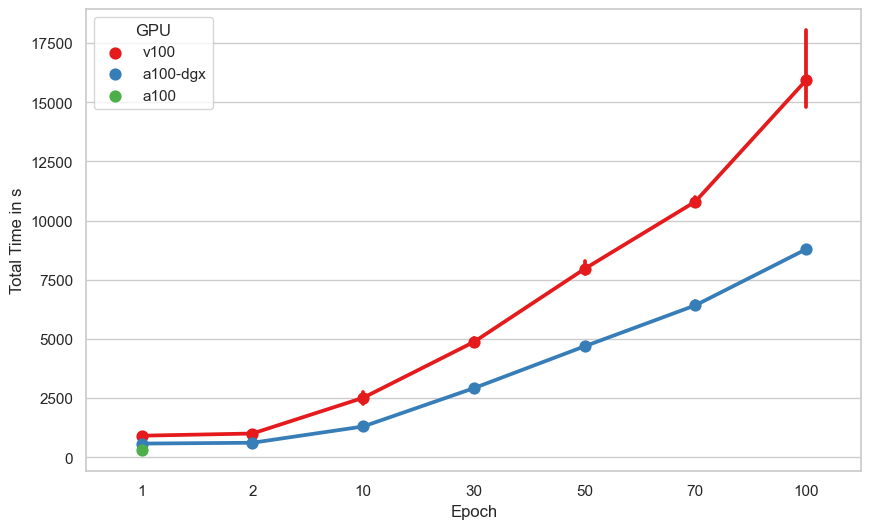

In [310]:
sns.set(style="whitegrid")

# Create a point plot using Seaborn
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
sns.pointplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Total Time in s')
plt.legend(title='GPU')

# Show the plot
plt.show()


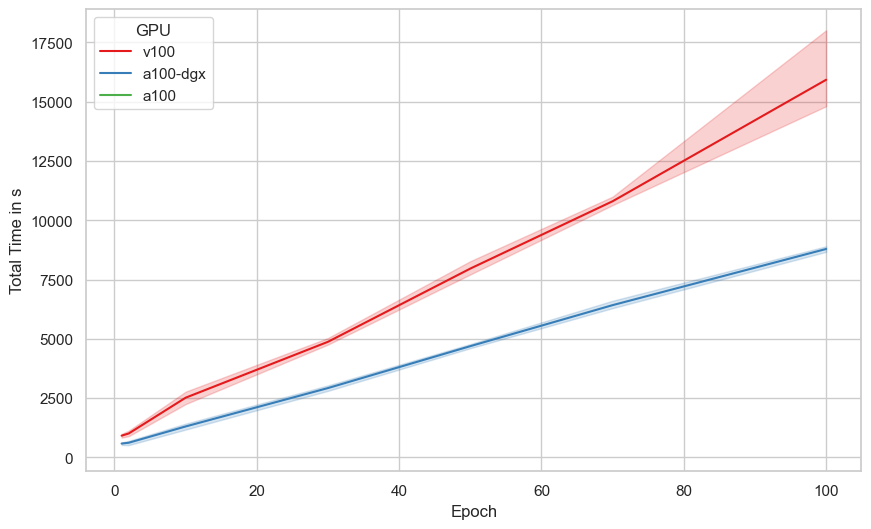

In [311]:

# Create a line plot using Seaborn
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plot = sns.lineplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')

# Add labels
plt.xlabel('Epoch')
plt.ylabel('Total Time in s')

# Get the current legend
legend = plt.legend(title='Directive')

# Change the label in the legend
legend.set_title('GPU')

# Show the plot
plt.show()


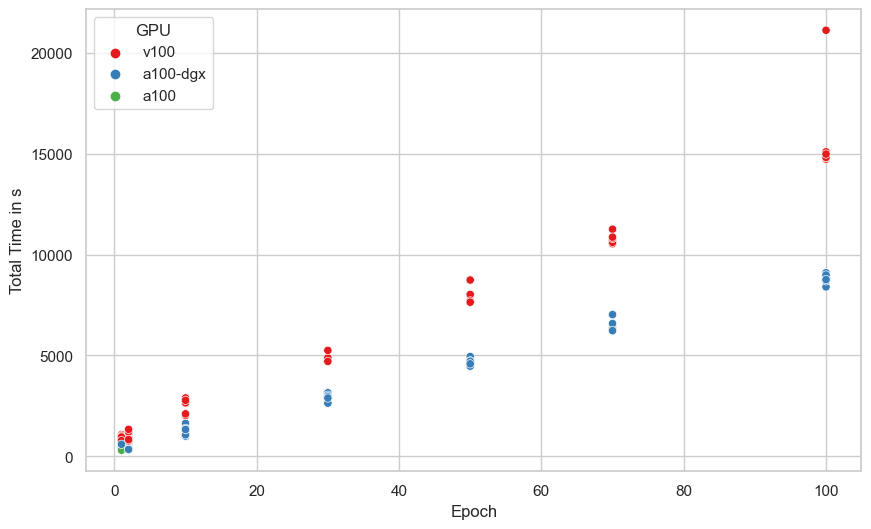

In [312]:

# Set the style of the plot
sns.set(style="whitegrid")

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
sns.scatterplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Total Time in s')
plt.legend(title='GPU')

# Show the plot
plt.show()

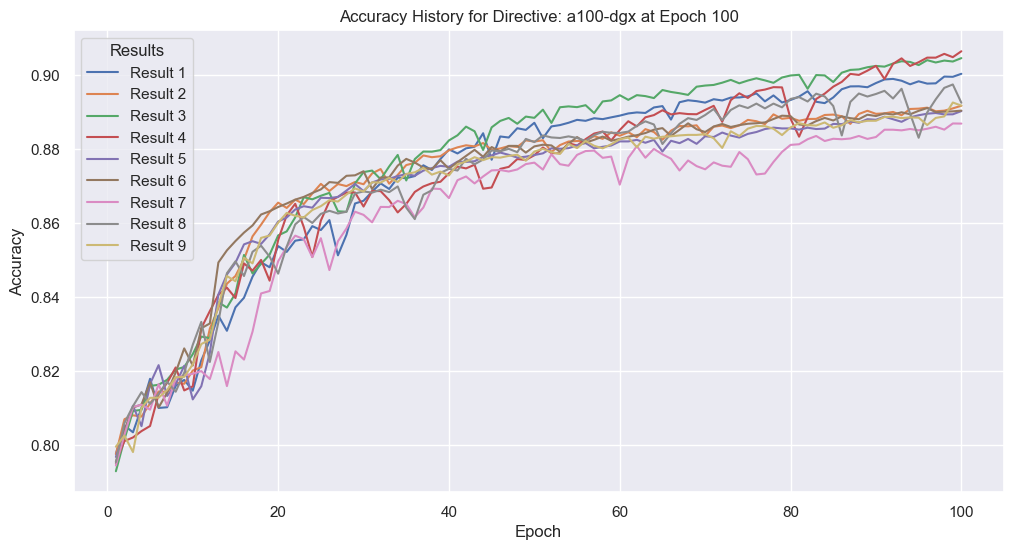

In [313]:


# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the directive you want to select
selected_directive = 'a100-dgx'  # Replace with your desired directive
selected_epoch = 100

# Filter the DataFrame for the selected directive and epoch
filtered_df = df[(df['directive'] == selected_directive) & (df['result'].apply(lambda x: len(x['value']['training']['history']['accuracy'])) >= selected_epoch)]

# Create an empty list to store accuracy histories
accuracy_histories = []

# Iterate through the filtered DataFrame and extract accuracy histories
for index, row in filtered_df.iterrows():
    result = row['result']
    accuracy_history = result['value']['training']['history']['accuracy']
    accuracy_histories.append(accuracy_history[:selected_epoch])

# Create a Seaborn line plot for all matching directives
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

for idx, accuracy_history in enumerate(accuracy_histories):
    sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch}')
plt.legend(title='Results')
plt.show()


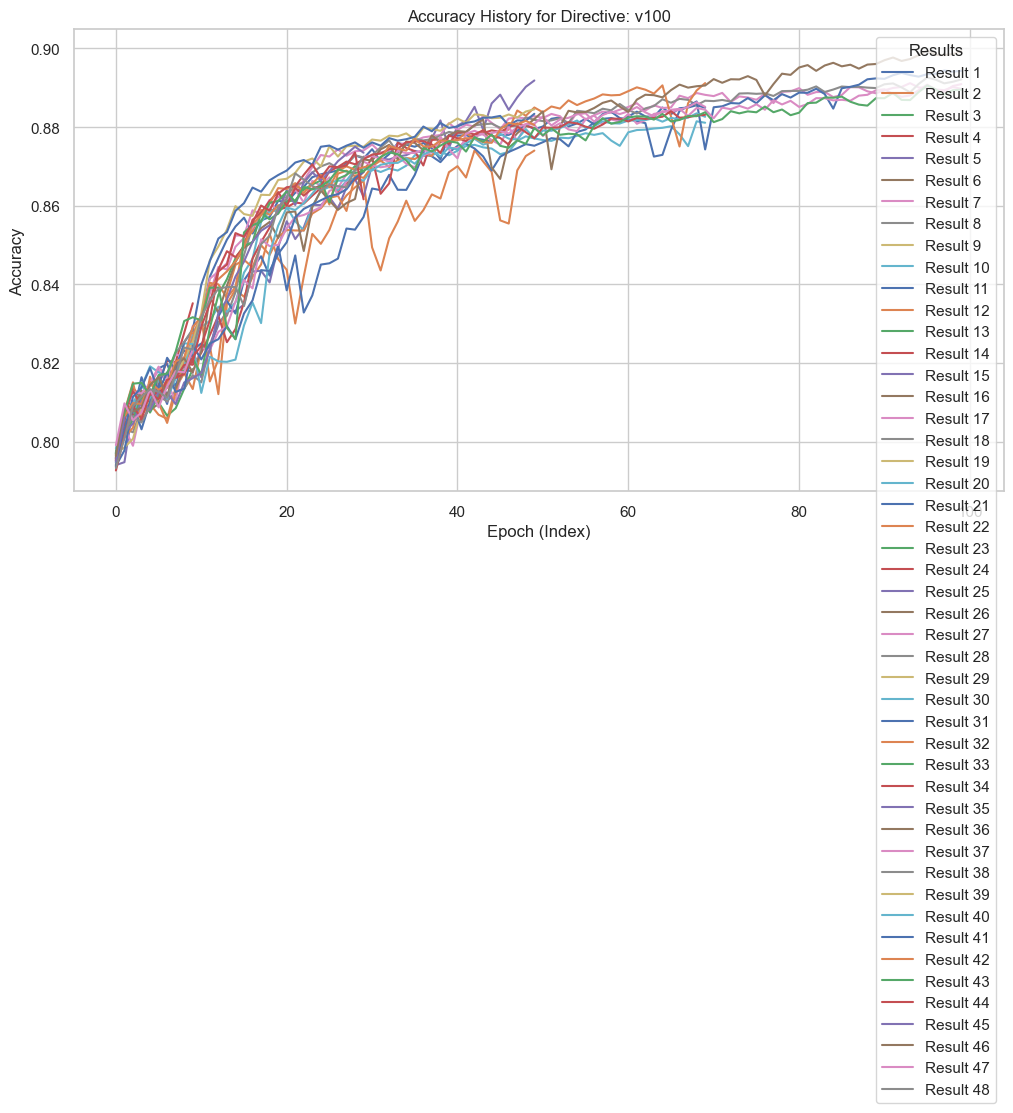

In [314]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the directive you want to plot
selected_directive = 'v100'  # Replace with your desired directive

# Filter the DataFrame for the selected directive
directive_df = df[df['directive'] == selected_directive]

# Extract all accuracy histories for the selected directive
accuracy_histories = directive_df['result'].apply(lambda x: x['value']['training']['history']['accuracy'])

# Create a Seaborn line plot for all accuracy histories
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for idx, accuracy_history in enumerate(accuracy_histories):
    x_values = list(range(len(accuracy_history)))
    sns.lineplot(x=x_values, y=accuracy_history, label=f'Result {idx + 1}')

plt.xlabel('Epoch (Index)')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directive: {selected_directive}')
plt.legend(title='Results')
plt.show()


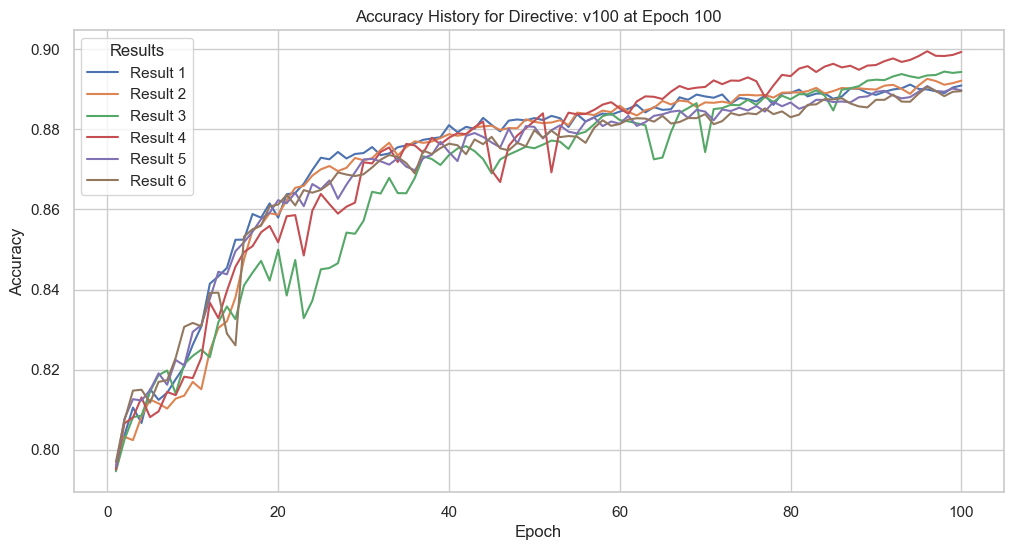

In [315]:


# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the directive you want to select
selected_directive = 'v100'  # Replace with your desired directive
selected_epoch = 100

# Filter the DataFrame for the selected directive and epoch
filtered_df = df[(df['directive'] == selected_directive) & (df['result'].apply(lambda x: len(x['value']['training']['history']['accuracy'])) >= selected_epoch)]

# Create an empty list to store accuracy histories
accuracy_histories = []

# Iterate through the filtered DataFrame and extract accuracy histories
for index, row in filtered_df.iterrows():
    result = row['result']
    accuracy_history = result['value']['training']['history']['accuracy']
    accuracy_histories.append(accuracy_history[:selected_epoch])

# Create a Seaborn line plot for all matching directives
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for idx, accuracy_history in enumerate(accuracy_histories):
    sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch}')
plt.legend(title='Results')
plt.show()

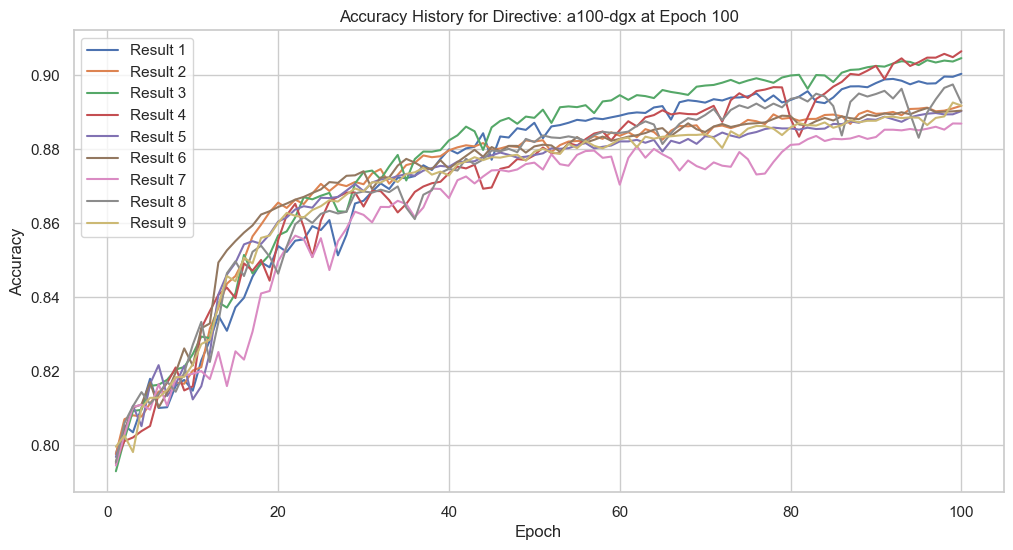

In [316]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the directive you want to select
selected_directive = 'a100-dgx'  # Replace with your desired directive
selected_epoch = 100

# Filter the DataFrame for the selected directive and epoch
filtered_df = df[(df['directive'] == selected_directive) & (df['result'].apply(lambda x: len(x['value']['training']['history']['accuracy'])) >= selected_epoch)]

# Create an empty list to store accuracy histories
accuracy_histories = []

# Iterate through the filtered DataFrame and extract accuracy histories
for index, row in filtered_df.iterrows():
    result = row['result']
    accuracy_history = result['value']['training']['history']['accuracy']
    accuracy_histories.append(accuracy_history[:selected_epoch])

# Create a Seaborn line plot for all matching directives without a legend
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for idx, accuracy_history in enumerate(accuracy_histories):
    sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch}')
plt.show()


In [317]:
def plot_history(data, epoch=100, directives=["a100-dgx","v100"], value="accuracy"):
    df = data[data['directive'].notna()].copy()
    
    # Specify the list of directives you want to select
    selected_directives = directives # ['a100-dgx', 'v100']  # Replace with your desired directives
    selected_epoch = epoch
    
    # Create an empty list to store accuracy histories for each directive
    accuracy_histories_dict = {directive: [] for directive in selected_directives}
    
    
    
    # Iterate through the DataFrame and extract accuracy histories for selected directives
    for directive in selected_directives:
        filtered_df = df[(df['directive'] == directive) & (df['result'].apply(lambda x: len(x['value']['training']['history'][value])) >= selected_epoch)]
        
        for index, row in filtered_df.iterrows():
            result = row['result']
            accuracy_history = result['value']['training']['history'][value]
            accuracy_histories_dict[directive].append(accuracy_history[:selected_epoch])
    
    # Create Seaborn line plots for each directive with a legend
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    for directive, accuracy_histories in accuracy_histories_dict.items():
        for idx, accuracy_history in enumerate(accuracy_histories):
            sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1}')
    
    plt.xlabel('Epoch')
    plt.ylabel(value.capitalize())
    plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
    plt.legend()
    plt.show()


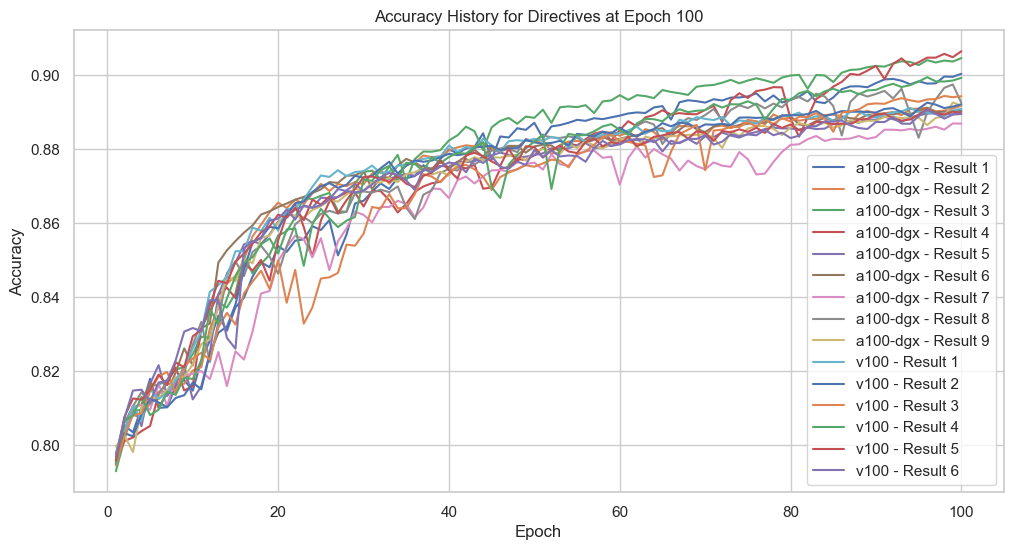

In [318]:

value = 'accuracy'
# Filter rows with valid directive names
df = df[df['directive'].notna()]

plot_history(df, directives=['a100-dgx', 'v100'], epoch=100, value="accuracy")



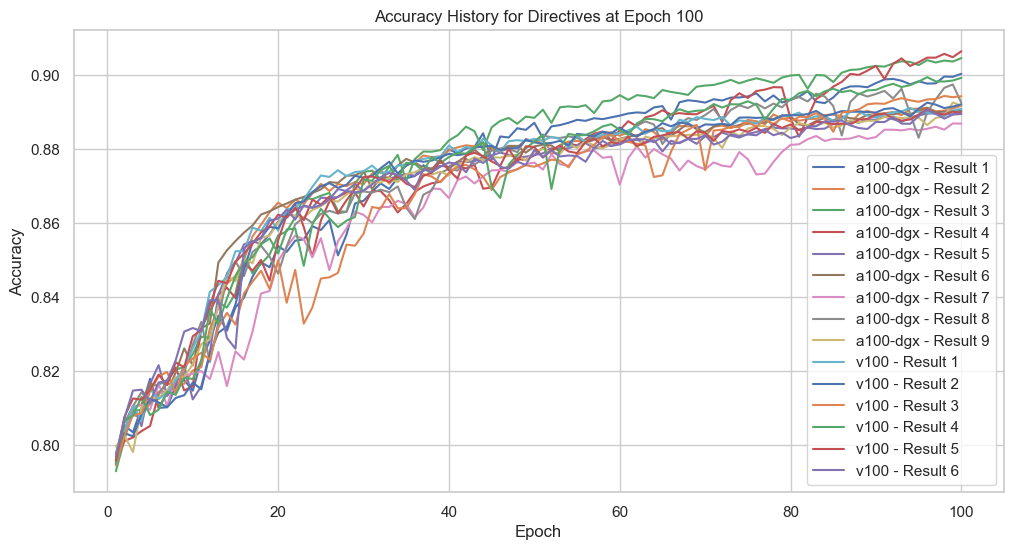

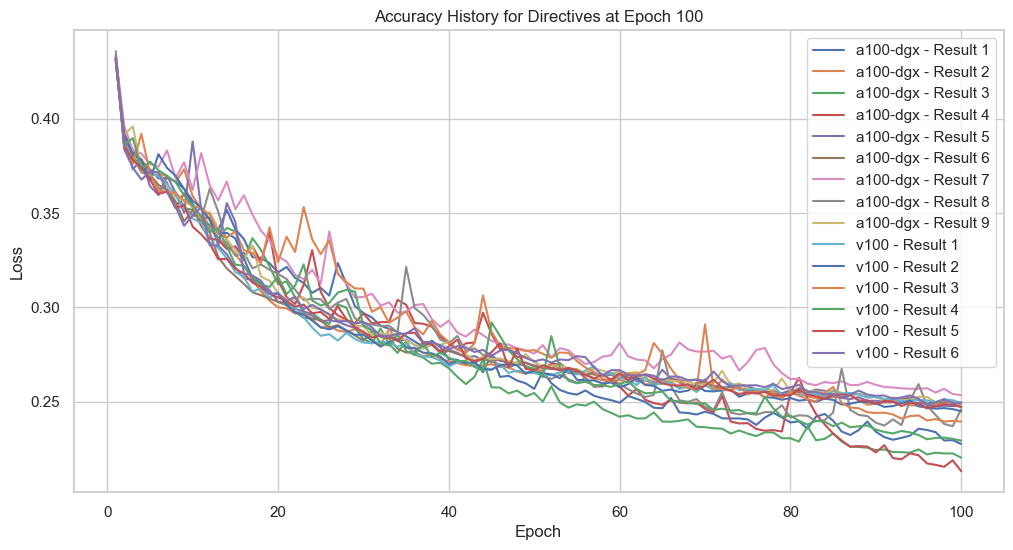

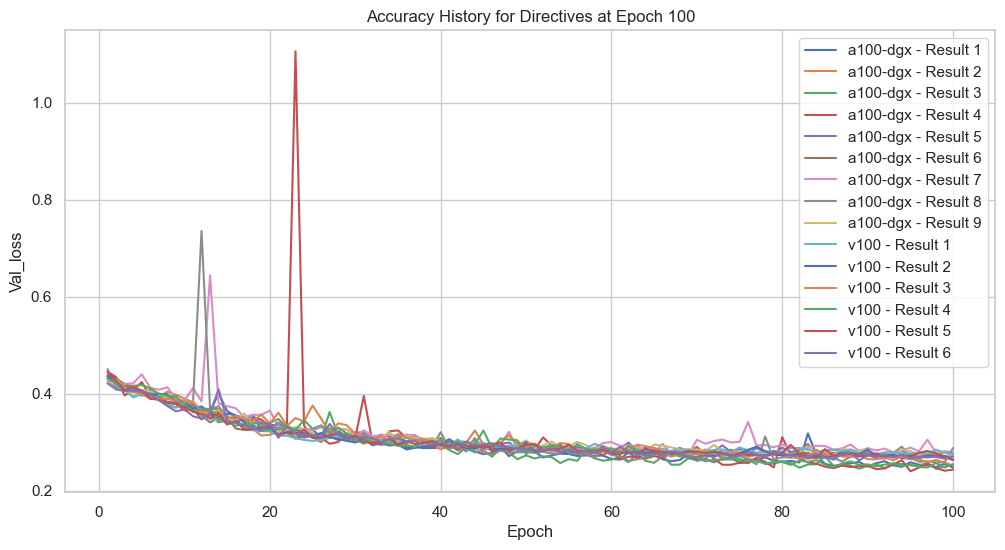

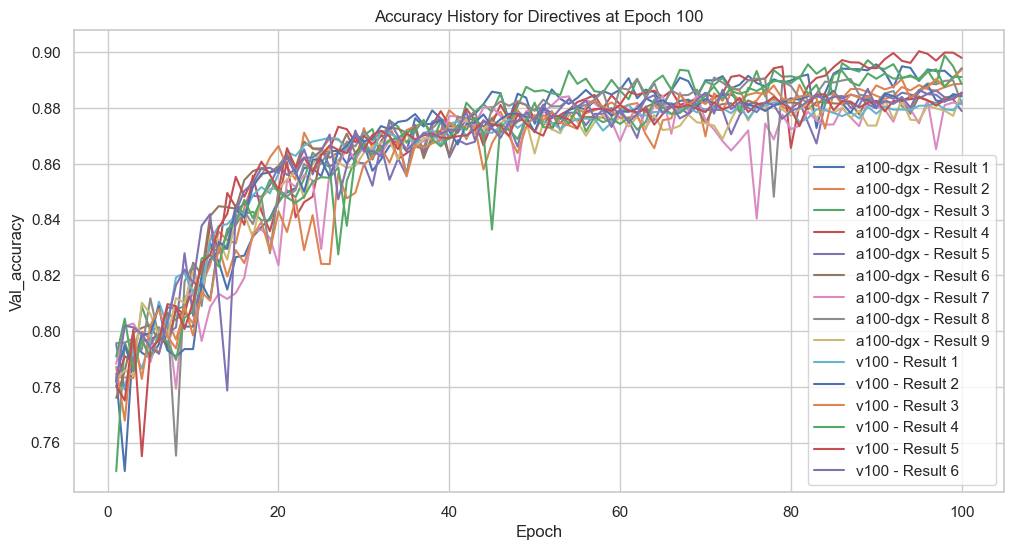

In [319]:
for k in result['value']['training']['history'].keys():
    plot_history(df, directives=['a100-dgx', 'v100'], epoch=100, value=k)

In [320]:
result['value']['training']['history'].keys()


dict_keys(['accuracy', 'loss', 'val_loss', 'val_accuracy'])

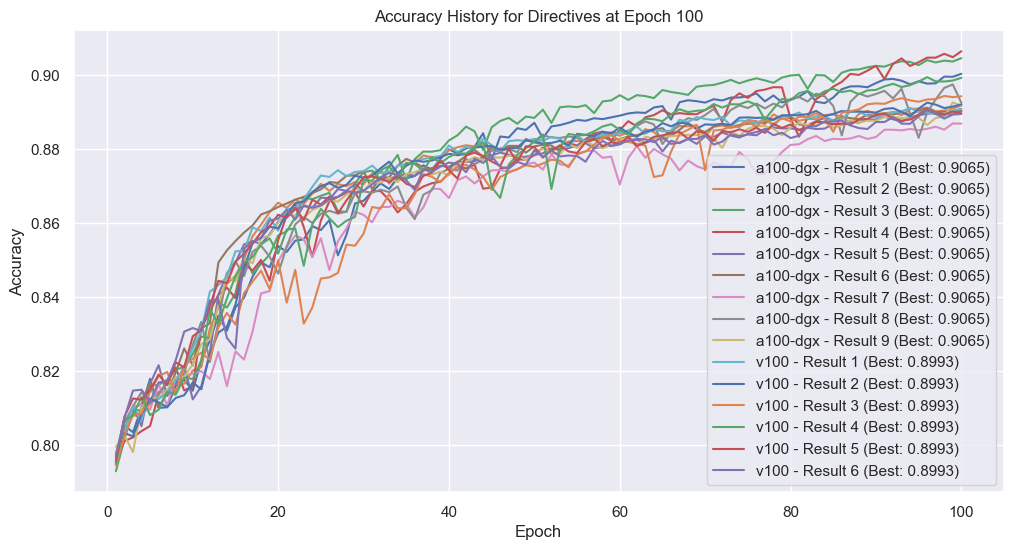

In [321]:

# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the list of directives you want to select
selected_directives = ['a100-dgx', 'v100']  # Replace with your desired directives
selected_epoch = 100

# Create a dictionary to store accuracy histories and best accuracies for each directive
directive_data = {}

# Iterate through the DataFrame and extract accuracy histories for selected directives
for directive in selected_directives:
    filtered_df = df[(df['directive'] == directive) & (df['result'].apply(lambda x: len(x['value']['training']['history']['accuracy'])) >= selected_epoch)]
    
    directive_accuracies = []
    
    for index, row in filtered_df.iterrows():
        result = row['result']
        accuracy_history = result['value']['training']['history']['accuracy']
        directive_accuracies.append(accuracy_history[:selected_epoch])
    
    # Calculate the best accuracy for this directive
    best_accuracy = max([accuracy[-1] for accuracy in directive_accuracies])
    
    directive_data[directive] = {
        'accuracies': directive_accuracies,
        'best_accuracy': best_accuracy
    }

# Sort directives by best accuracy in descending order
sorted_directives = sorted(directive_data.keys(), key=lambda x: directive_data[x]['best_accuracy'], reverse=True)

# Create Seaborn line plots for each directive with a legend
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

for directive in sorted_directives:
    for idx, accuracy_history in enumerate(directive_data[directive]['accuracies']):
        best_accuracy = directive_data[directive]['best_accuracy']
        sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1} (Best: {best_accuracy:.4f})')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
plt.legend()
plt.show()


In [322]:
print(result_data[0])

{'name': 'result-thf2bn-53854471.out', 'total': 10739.745, 'training': 10590.6, 'loaddata': 4.118, 'inference': 144.679, 'directive': 'v100', 'gpu_count': '1', 'cpu_num': 1, 'mem': '64GB', 'repeat': '5', 'epoch': '70', 'seed': 1234, 'learning_rate': 0.001, 'batch_size': 32, 'train_split': 0.8, 'clip_offset': 15, 'no_cache': False, 'nodes': 1, 'gpu': 1, 'early_stoppage_patience': '25', 'early_stoppage': 'False', 'card_name': 'v100', 'result': {'value': {'name': 'cloudmask', 'training': {'samples': 970, 'accuracy': 0.8849480152130127, 'loss': 0.2601945102214813, 'val_loss': 0.2793876826763153, 'val_accuracy': 0.8799592852592468, 'history': {'accuracy': [0.7971559762954712, 0.8036167621612549, 0.8068755269050598, 0.8164012432098389, 0.8104918003082275, 0.8150579929351807, 0.809596598148346, 0.8198840618133545, 0.8231695294380188, 0.8217014074325562, 0.8314782977104187, 0.8419565558433533, 0.8467669486999512, 0.851389467716217, 0.8547239303588867, 0.8569662570953369, 0.8529560565948486, 0.

In [323]:
accuracy_list = []
loss_list = []
val_accuracy_list = []
val_loss_list = []

# Iterate through the list of dictionaries and extract the values
for entry in result_data:
    accuracy_list.extend(entry['result']['value']['inference']['accuracy'])
    loss_list.extend(entry['result']['value']['training']['history']['loss'])
    val_accuracy_list.extend(entry['result']['value']['training']['history']['val_accuracy'])
    val_loss_list.extend(entry['result']['value']['training']['history']['val_loss'])
    
print ("OOOO")
print (len(accuracy_list))
print (len(loss_list))
print (len(val_accuracy_list))
print (len(val_loss_list))

# Create a DataFrame with the extracted values
df = pd.DataFrame({
#    'Accuracy': accuracy_list,
    'Loss': loss_list,
    'Val_Accuracy': val_accuracy_list,
    'Val_Loss': val_loss_list
})
df['Index'] = range(1, len(df) + 1)
# Display the DataFrame
df

OOOO
11100
3868
3868
3868


,Loss,Val_Accuracy,Val_Loss,Index
0,0.430577,0.776794,0.453891,1
1,0.386824,0.775540,0.430620,2
2,0.376532,0.801155,0.401342,3
3,0.371918,0.795250,0.420809,4
4,0.372598,0.803972,0.395189,5
...,...,...,...,...
3863,0.293370,0.866613,0.312281,3864
3864,0.292041,0.866306,0.307600,3865
3865,0.292379,0.863489,0.318265,3866
3866,0.288750,0.862671,0.312229,3867


In [324]:
print(df.head)


<bound method NDFrame.head of           Loss  Val_Accuracy  Val_Loss  Index
0     0.430577      0.776794  0.453891      1
1     0.386824      0.775540  0.430620      2
2     0.376532      0.801155  0.401342      3
3     0.371918      0.795250  0.420809      4
4     0.372598      0.803972  0.395189      5
...        ...           ...       ...    ...
3863  0.293370      0.866613  0.312281   3864
3864  0.292041      0.866306  0.307600   3865
3865  0.292379      0.863489  0.318265   3866
3866  0.288750      0.862671  0.312229   3867
3867  0.429758      0.771661  0.435519   3868

[3868 rows x 4 columns]>


In [325]:
n = 10
sorted_loss_df = df.sort_values(by='Loss', ascending=True)
sorted_loss_df.head(n)


,Loss,Val_Accuracy,Val_Loss,Index
1083,0.213068,0.898055,0.243567,1084
1081,0.215439,0.899954,0.247064,1082
1080,0.216453,0.897066,0.255360,1081
1079,0.217210,0.899515,0.247711,1080
1082,0.218885,0.899921,0.241348,1083
1076,0.219385,0.896986,0.254129,1077
1075,0.220052,0.899768,0.246114,1076
547,0.220269,0.888677,0.254200,548
1078,0.221557,0.900421,0.240277,1079
543,0.221967,0.893634,0.251591,544


In [326]:
n = 10
sorted_loss_df = df.sort_values(by='Val_Accuracy', ascending=False)
sorted_loss_df.head(n)

,Loss,Val_Accuracy,Val_Loss,Index
1078,0.221557,0.900421,0.240277,1079
1081,0.215439,0.899954,0.247064,1082
1082,0.218885,0.899921,0.241348,1083
1075,0.220052,0.899768,0.246114,1076
1079,0.217210,0.899515,0.247711,1080
545,0.222495,0.898925,0.245414,546
1083,0.213068,0.898055,0.243567,1084
1074,0.226875,0.897595,0.244554,1075
1069,0.229369,0.897237,0.246573,1070
536,0.225548,0.897211,0.245603,537


In [327]:
n = 10
sorted_loss_df = df.sort_values(by='Val_Loss', ascending=True)
sorted_loss_df.head(n)

,Loss,Val_Accuracy,Val_Loss,Index
1078,0.221557,0.900421,0.240277,1079
1082,0.218885,0.899921,0.241348,1083
1083,0.213068,0.898055,0.243567,1084
1074,0.226875,0.897595,0.244554,1075
545,0.222495,0.898925,0.245414,546
536,0.225548,0.897211,0.245603,537
1075,0.220052,0.899768,0.246114,1076
1069,0.229369,0.897237,0.246573,1070
539,0.223255,0.895780,0.246660,540
1081,0.215439,0.899954,0.247064,1082


In [328]:
df = pd.DataFrame({
    'Accuracy': accuracy_list,
})
df['Index'] = range(1, len(df) + 1)
# Display the DataFrame
df

,Accuracy,Index
0,0.923344,1
1,0.934509,2
2,0.894077,3
3,0.910514,4
4,0.839129,5
...,...,...
11095,0.751298,11096
11096,0.867493,11097
11097,0.718101,11098
11098,0.826334,11099


In [329]:
n = 10
sorted_accuracy_loss = df.sort_values(by='Accuracy', ascending=False)
sorted_accuracy_loss.head(n)


,Accuracy,Index
3009,0.989144,3010
3022,0.988317,3023
3005,0.984737,3006
3057,0.980435,3058
3094,0.969111,3095
3092,0.967100,3093
1709,0.964410,1710
2209,0.964246,2210
1409,0.964241,1410
3209,0.964086,3210
